In [139]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sklearn import tree
import copy

In [2]:
def get_phase_name(phaseid, ds_phase_names):
    return ds_phase_names['Phase_englisch'][ds_phase_names['Phase_ID'] == str(phaseid)].values[0]

In [3]:
def get_station_locations(dataset, ds_stations):
    ds_stations.index = ds_stations['Stations_id']
    lat = [ds_stations._get_value(row, col) for row, col in zip(dataset['Stations_id'], ['geograph.Breite' for count in range(len(dataset))])] #station_data.lookup(row_labels = dataset['Stations_id'], col_labels = ['geograph.Breite'])
    lon = [ds_stations._get_value(row, col) for row, col in zip(dataset['Stations_id'], ['geograph.Laenge' for count in range(len(dataset))])] #station_data._lookup(dataset['Stations_id'], ['geograph.Laenge'])
    return lat, lon

In [4]:
def phase_dependent_response(driver_values, t_dev, responses, thresholds):
    #Thresholds are the thresholds in development time where the different growth phases change
    #Responses are the response functions, index starting at 'before the first threshold'
    #driver values are the inputs to the response function
    #t_dev is the (cts) development time
    phase = np.digitize(t_dev, thresholds)
    response = np.zeros(driver_values.shape)
    for phase_index in range(len(responses)):
        response += (phase == phase_index)*responses[phase_index](driver_values) #First brackets indicates if we are at the right phase, second takes the response function for each phase
    return response

In [74]:
def isolate_stage(phen_data, stage):
    return phen_data[phen_data['Name of phase'] == stage]

In [75]:
def time_stage_to_stage(phen_data, stage1, stage2, winter_sowing = False):
    stage1_frame = isolate_stage(phen_data, stage1)
    if winter_sowing: #If the first stage is actually in winter of the previous year, compare the first stage to the year after.
        stage1_frame.loc[:, 'Referenzjahr'] = stage1_frame.loc[:, 'Referenzjahr'] + 1
    stage1_frame.set_index(['Stations_id', 'Referenzjahr'], inplace=True)
    stage2_frame = isolate_stage(phen_data, stage2)
    stage2_frame.set_index(['Stations_id', 'Referenzjahr'], inplace=True)
    print()
    return (stage2_frame['Eintrittsdatum'] - stage1_frame['Eintrittsdatum'])/ pd.to_timedelta(1, unit='D') #.astype(np.float64)

In [5]:
def interpolate_xy(x, y, ds):
    #Interpolates the input array onto the (non-gridded e.g. phenology station) coordinates x and y.
    #Note hyras is not stored on the full grid, but on some kind of subset. Not quite sure how this works. Just got to hope the stations are in a hyras gridpoint.
    X_for_interp = xr.DataArray(x, dims="modelpoint")
    Y_for_interp = xr.DataArray(y, dims="modelpoint")
    return ds.interp(x=X_for_interp, y=Y_for_interp)#, kwargs={"fill_value": None})

In [6]:
def latlon_to_projection(x_coords, y_coords):
    proj_epsg = ccrs.epsg(3034)
    proj_latlon = ccrs.PlateCarree()
    points_epsg = proj_epsg.transform_points(proj_latlon, x_coords, y_coords)
    x_epsg = points_epsg[:, 0]
    y_epsg = points_epsg[:, 1]
    return x_epsg, y_epsg

In [52]:
def Wang_Engel_Temp_response(T, T_min, T_opt, T_max, beta = 1):
    alpha = np.log(2)/np.log( (T_max - T_min)/(T_opt - T_min) )
    f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta
    f_T = np.nan_to_num(f_T)
    return f_T*(T >= T_min)*(T<= T_max)

In [53]:
def Trapezoid_Temp_response(T, T_min, T_opt1, T_opt2, T_max):
    pre_opt = (T>=T_min)*(T<=T_opt1)
    opt = (T>=T_opt1)*(T<=T_opt2)
    post_opt = (T>=T_opt2)*(T<=T_max)
    return pre_opt*(T - T_min)/(T_opt1 - T_min) + opt + post_opt*(T_max - T)/(T_max - T_opt2)

In [106]:
class Phenology_set:

    phase_names = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phase.txt", encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
    station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')

    def __init__(self, address):
        self.phen_data = pd.read_csv(address, encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
        ## CONVERT DATE TO DATETIME ##
        self.phen_data['Eintrittsdatum'] = pd.to_datetime(self.phen_data['Eintrittsdatum'], format = '%Y%m%d')
        self.phen_data = self.phen_data.drop(self.phen_data[self.phen_data['Qualitaetsniveau'] != 10].index)
        #print(self.phen_data['Qualitaetsniveau'].values)
        self.T_mean = ''
        self.GDD_driver_data = ''
        self.ordered = False

    ### Functions for sorting out dataset ###
    def drop_columns(self, drop_list):
        for drop_name in drop_list:
            self.phen_data = self.phen_data.drop(drop_name, axis = 1)
    
    def phase_order_name(self, stage_order): #[10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ]
        self.phen_data['Order of phase'] = np.nan
        self.phen_data['Name of phase'] = ''
        for i, phaseid in enumerate(stage_order):
            if len(self.phase_names['Phase_englisch'][self.phase_names['Phase_ID'] == str(phaseid)]) != 0:
                #print(i, phaseid)
                self.phen_data.loc[self.phen_data['Phase_id'] == phaseid, 'Order of phase'] = i
                self.phen_data.loc[self.phen_data['Phase_id'] == phaseid, 'Name of phase'] = get_phase_name(phaseid, self.phase_names)

    def order_phen_dataset(self):
        ## SORT BY TIME ##
        if not(np.isin('Order of phase', self.phen_data.columns)):
            print('Get phase order and names first')
        else:
            self.phen_data.sort_values(by = ['Stations_id', 'Referenzjahr', 'Eintrittsdatum', 'Order of phase'])
            self.ordered = True
    
    def get_time_to_next_stage(self):
        #Note phen_data must be time and station ordered. Only plots time to next stage - naive as doesn't consider missing phases.
        if self.ordered:
            ## CALCULATE TIME TO NEXT STAGE ##
            self.phen_data['Time to next stage'] = self.phen_data['Eintrittsdatum'].shift(-1) - self.phen_data['Eintrittsdatum']
            self.phen_data['Next stage name'] = self.phen_data['Name of phase'].shift(-1)
            ## EXCLUDE CHANGES IN STATION ##
            self.phen_data.loc[self.phen_data['Stations_id'] != self.phen_data['Stations_id'].shift(-1), 'Time to next stage'] = np.nan
            self.phen_data.loc[self.phen_data['Stations_id'] != self.phen_data['Stations_id'].shift(-1), 'Next stage name'] = np.nan
        else:
            print('Order dataset so I can get time to next stage')

    def add_locations(self):
        LAT, LON = get_station_locations(self.phen_data, self.station_data)
        self.phen_data['lat'] = LAT
        self.phen_data['lon'] = LON
        self.phen_data['lat'] = self.phen_data['lat'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
        self.phen_data['lon'] = self.phen_data['lon'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)

    ### Functions for applying GDD model ###
    def get_mean_T(self, T_address):
        self.T_mean = xr.open_dataset(T_address)

    def make_input_array(self):
        just_emergence_phen_data = self.phen_data.where(self.phen_data['Name of phase'] == 'beginning of emergence').dropna()
        just_emergence_phen_data = just_emergence_phen_data.where(just_emergence_phen_data['Eintrittsdatum'] > np.datetime64('2005-01-01')).dropna()
        x_coords = just_emergence_phen_data['lon'].values
        y_coords = just_emergence_phen_data['lat'].values
        #Makes an array to put into GDD model
        print('project to new coords')
        x_epsg, y_epsg = latlon_to_projection(x_coords, y_coords)
        print('interpolate driver to station locations')
        self.GDD_driver_data = interpolate_xy(x_epsg, y_epsg, self.T_mean)
        self.GDD_driver_data['emergence_dates'] = (("modelpoint"), just_emergence_phen_data['Eintrittsdatum'].values)
        self.GDD_driver_data['Stations_id'] = (("modelpoint"), just_emergence_phen_data['Stations_id'].values)
        self.GDD_driver_data['Referenzjahr'] = (("modelpoint"), just_emergence_phen_data['Referenzjahr'].values)
        self.GDD_driver_data = self.GDD_driver_data.assign_coords(modelpoint=np.arange(self.GDD_driver_data.sizes['modelpoint']))
    
    def dev_under_response(self, response, driver_variable, maturity_t_dev):
        # Response is the rate response to driver values. Driver values are the input to this response. Maturity_t_dev is the t_dev value where we should stop running.
        if type(self.GDD_driver_data) == str:
            print('Make a dataset for the driving variable first')
        else:
            t_dev = np.zeros(self.GDD_driver_data[driver_variable].isel(time=0).values.shape) #Continuous development time. When this passes through some thresholds then have change in phase.
            dev_time_series = [t_dev.copy()]
            i_day = self.GDD_driver_data['emergence_dates'].values.copy()
            i_day = i_day + np.timedelta64(12, 'h') #so that times are at midday rather than midnight
            time_indexer = xr.DataArray(i_day, dims=["modelpoint"])
            #self.GDD_driver_data.sel(time=time_indexer, method='nearest')
            for day_count in range(365):#while np.sum(t_dev < maturity_t_dev) > 0.05*len(ds_driver['modelpoint']):
                print(day_count)
                driver_values = self.GDD_driver_data.sel(time=time_indexer, method='nearest')[driver_variable].values
                print(len(driver_values[t_dev<maturity_t_dev]))
                t_dev += response(driver_values, t_dev) #Rate of change of development stage
                dev_time_series.append(t_dev.copy())
                i_day += np.timedelta64(1,'D')
            self.model_dev_time_series = np.array(dev_time_series)

    def get_phase_dates(self, thresholds):
        self.phase_dates_array = np.zeros((len(thresholds), self.model_dev_time_series.shape[1]))
        for obs_index in range(self.model_dev_time_series.shape[1]):
            self.phase_dates_array[:, obs_index] = np.digitize(thresholds, self.model_dev_time_series[:, obs_index]) #Note that the thresholds are NOT the bins for numpy digitize!
    
    def get_modelled_dataset(self, phase_list = []):
        if len(phase_list) == 0:
            computed_phases = [f'modelled time emergence to phase {i + 1}' for i in range(self.phase_dates_array.shape[0])]
        else:
            computed_phases = [f'modelled time emergence to {phase}' for phase in phase_list]
            #Initialize dataset for comparison with station IDs and years
        data_comparison = {'Stations_id': np.int64(self.GDD_driver_data['Stations_id'].values),
                        'Referenzjahr': np.int64(self.GDD_driver_data['Referenzjahr'].values),
                        }
        self.ds_comparison = pd.DataFrame(data_comparison)
        #Add modelled phase dates etc. to the comparison set.
        for phase_index, phase in enumerate(computed_phases):
            self.ds_comparison[phase] = self.phase_dates_array[phase_index, :]
        self.ds_comparison.set_index(['Stations_id', 'Referenzjahr'], inplace=True)
    
    ## Functions for evaluation ##
    def get_observed_dataset(self, phase_list):
        observed_to_first_stage = time_stage_to_stage(self.phen_data, 'beginning of emergence', phase_list[0]).dropna()
        self.ds_observed = pd.DataFrame({f'observed time emergence to {phase_list[0]}': observed_to_first_stage})
        for phase in phase_list[1:]:
            self.ds_observed[f'observed time emergence to {phase}'] = time_stage_to_stage(self.phen_data, 'beginning of emergence', phase).dropna()
    
    def compare_modelled_observed(self):
        self.full_dataset = pd.concat([self.ds_comparison, self.ds_observed], axis = 1)
        
    def get_X_for_ML(self, driver_variable, predictor_days = 200):
        i_day = self.GDD_driver_data['emergence_dates'].values.copy()
        i_daysofyear = np.array([i_day + np.timedelta64(12, 'h') + np.timedelta64(day_of_year, 'D') for day_of_year in range(predictor_days)]) #so that times are at midday rather than midnight
        time_indexer = xr.DataArray(i_daysofyear, dims=[ "time", 'modelpoint'])
        self.GDD_data_for_ML = self.GDD_driver_data.sel(time=time_indexer, method='nearest')
        for phase in phase_list:
            self.GDD
        self.X_for_ML = self.GDD_data_for_ML[driver_variable].values.T
    


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_12224\961152602.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [155]:
def get_X_for_ML(phenset, driver_variable, predictor_days = 200):
    i_day = phenset.GDD_driver_data['emergence_dates'].values.copy()
    i_daysofyear = np.array([i_day + np.timedelta64(12, 'h') + np.timedelta64(day_of_year, 'D') for day_of_year in range(predictor_days)]) #so that times are at midday rather than midnight
    time_indexer = xr.DataArray(i_daysofyear, dims=[ "time", 'modelpoint'])
    phenset.GDD_data_for_ML = phenset.GDD_driver_data.sel(time=time_indexer, method='nearest')
    for variable in phenset.ds_observed.columns:
        
    #phenset.GDD_data_for_ML = xr.concat([phenset.GDD_data_for_ML, phenset.ds_observed], dim)
    #phenset.X_for_ML = phenset.GDD_data_for_ML[driver_variable].values.T

In [140]:
i_day = Maize_set.GDD_driver_data['emergence_dates'].values.copy()
i_daysofyear = np.array([i_day + np.timedelta64(12, 'h') + np.timedelta64(day_of_year, 'D') for day_of_year in range(200)]) #so that times are at midday rather than midnight
time_indexer = xr.DataArray(i_daysofyear, dims=[ "time", 'modelpoint'])
Maize_set.GDD_data_for_ML = Maize_set.GDD_driver_data.sel(time=time_indexer, method='nearest')

In [161]:
Maize_set.GDD_data_for_ML = Maize_set.GDD_data_for_ML.set_coords('Referenzjahr')

In [195]:
Maize_set.ds_observed.index.get_level_values(1)

Index([1999, 2000, 2004, 2005, 2007, 2008, 2009, 2010, 2011, 2012,
       ...
       2007, 2008, 2009, 2011, 2014, 2016, 2017, 2018, 2019, 2022],
      dtype='int64', name='Referenzjahr', length=27886)

In [196]:
Maize_set.GDD_data_for_ML.sel(modelpoint=np.isin(Maize_set.GDD_data_for_ML['Referenzjahr'], Maize_set.ds_observed.index.get_level_values(1)))#.where(Maize_set.GDD_data_for_ML)

<xarray.Dataset>
Dimensions:             (time: 200, modelpoint: 13608, bnds: 2)
Coordinates:
    time                (time, modelpoint) datetime64[ns] 2005-05-08T12:00:00...
    lon                 (modelpoint) float64 10.05 10.05 10.05 ... 9.363 9.363
    lat                 (modelpoint) float64 54.32 54.32 54.32 ... 50.32 50.32
    x                   (modelpoint) float64 4.003e+06 4.003e+06 ... 3.956e+06
    y                   (modelpoint) float64 3.049e+06 3.049e+06 ... 2.619e+06
    Stations_id         (modelpoint) float64 7.504e+03 7.504e+03 ... 1.991e+04
    Referenzjahr        (modelpoint) float64 2.005e+03 2.007e+03 ... 2.022e+03
  * modelpoint          (modelpoint) int32 0 1 2 3 4 ... 13604 13605 13606 13607
Dimensions without coordinates: bnds
Data variables:
    time_bnds           (time, modelpoint, bnds) datetime64[ns] 2005-05-08 .....
    x_bnds              (modelpoint, bnds) float64 4.001e+06 ... 3.959e+06
    y_bnds              (modelpoint, bnds) float64 3.047e+06 ... 2.622e+06
    crs_HYRAS           int32 1
    tas                 (time, modelpoint) float64 6.442 10.27 ... 5.353 1.337
    number_of_stations  (time, modelpoint) float64 1.494e+03 ... 1.456e+03
    emergence_dates     (modelpoint) datetime64[ns] 2005-05-08 ... 2022-05-16
Attributes: (12/19)
    source:                 surface observations
    Conventions:            CF-1.8
    realization:            v5.0
    project_id:             HYRAS
    input_data_status:      non-realtime
    level_type:             surface
    ...                     ...
    horizontal_resolution:  5 km
    title:                  gridded_temperature_dataset_(HYRAS-DE TAS)
    institution:            Deutscher Wetterdienst (DWD)
    creation_date:          created at 2022-12-04 13:12:56
    filename:               tas_hyras_5_1951_2020_v5-0_de.nc
    unique_dataset_id:      DWD_HYRAS_DE_tas_v5.0_1951_2020_day_00638C9CD8

In [201]:
flowering_obs = xr.Dataset(data_vars = {'observed time emergence to beginning of flowering':(['modelpoint'], Maize_set.ds_observed['observed time emergence to beginning of flowering'].values)},
                           coords = {'Referenzjahr':(['modelpoint'], Maize_set.ds_observed.index.get_level_values(1)),
                                     'Stations_id':(['modelpoint'], Maize_set.ds_observed.index.get_level_values(0))}
)
#xr.merge([Maize_set.GDD_data_for_ML, flowering_obs])
flowering_obs.combine_first(Maize_set.GDD_data_for_ML)
#Maize_set.GDD_data_for_ML.assign({'observed time emergence to beginning of flowering':Maize_set.ds_observed['observed time emergence to beginning of flowering']}, dim = 'modelpoint')

ValueError: cannot reindex or align along dimension 'modelpoint' because of conflicting dimension sizes: {13608, 27886} (note: an index is found along that dimension with size=13608)

In [186]:
Maize_set.ds_observed.index.get_level_values(0)#['Referenzjahr']

Index([ 7504,  7504,  7504,  7504,  7504,  7504,  7504,  7504,  7504,  7504,
       ...
       19914, 19914, 19914, 19914, 19914, 19914, 19914, 19914, 19914, 19914],
      dtype='int64', name='Stations_id', length=27886)

In [178]:
flowering_obs

<xarray.Dataset>
Dimensions:                                            (modelpoint: 27886)
Dimensions without coordinates: modelpoint
Data variables:
    observed time emergence to beginning of flowering  (modelpoint) float64 6...

In [156]:
get_X_for_ML(Maize_set, 'tas')

TypeError: concat() missing 1 required positional argument: 'dim'

In [143]:
Maize_set.GDD_data_for_ML['tas'].values.shape
## NOTE FOR SCIKIT LEARN AXIS 0 GIVES THE LIST OF EXAMPLES ##

(200, 13608)

In [153]:
Maize_set.ds_observed[~np.isnan(Maize_set.ds_observed['observed time emergence to yellow ripeness'])]
Maize_set.GDD_driver_data

observed time emergence to beginning of flowering  \
Stations_id Referenzjahr                                                      
7504        1999                                                       64.0   
            2007                                                       80.0   
            2008                                                       77.0   
            2009                                                       83.0   
            2010                                                       71.0   
...                                                                     ...   
19755       2016                                                      102.0   
19760       1994                                                       68.0   
            1995                                                       65.0   
19914       1993                                                       69.0   
            2014                                                       73.0   

                          observed time emergence to yellow ripeness  
Stations_id Referenzjahr                                              
7504        1999                                               115.0  
            2007                                               145.0  
            2008                                               147.0  
            2009                                               126.0  
            2010                                               140.0  
...                                                              ...  
19755       2016                                               160.0  
19760       1994                                               141.0  
            1995                                               142.0  
19914       1993                                               119.0  
            2014                                               126.0  

[18789 rows x 2 columns]

In [145]:
np.array([[0, 0], [1, 1], [2, 2]]).shape

(3, 2)

In [108]:
Maize_set = Phenology_set("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\PH_Jahresmelder_Landwirtschaft_Kulturpflanze_Mais_1936_2023_hist.txt")
Maize_set.drop_columns(['Unnamed: 9'])

In [111]:
Maize_set.phase_order_name([10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ])
Maize_set.order_phen_dataset()

In [112]:
Maize_set.get_mean_T('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\tas_hyras_5_1951_2020_v5-0_de.nc')
Maize_set.add_locations()
Maize_set.make_input_array()

project to new coords
interpolate driver to station locations


In [ ]:
resps = [lambda x: Wang_Engel_Temp_response(x, 0, 27.5, 40), lambda x: Wang_Engel_Temp_response(x, 0, 33, 44)]
thresholds = [45, 65]
Maize_set.dev_under_response(lambda x, y: phase_dependent_response(x, y, resps, thresholds), 
                             'tas', thresholds[-1])
Maize_set.get_phase_dates(thresholds)

In [114]:
Maize_set.get_observed_dataset(phase_list=['beginning of flowering', 'yellow ripeness'])
Maize_set.get_modelled_dataset(phase_list=['beginning of flowering', 'yellow ripeness'])
Maize_set.compare_modelled_observed()

In [126]:
def box_plot_modelled_observed(ds, phases, font_size = 20):
    for phase in phases:
        fig, ax = plt.subplots(figsize = (10, 10))
        ax.boxplot([ds[f'modelled time emergence to {phase}'].dropna(), ds[f'observed time emergence to {phase}'].dropna()], 
                   tick_labels=[f'modelled time emergence to\n{phase}', f'observed time emergence to\n{phase}'], 
                   widths = 0.5, showfliers=False) #positions = [obs_this_phase['Stations_id'].unique()[0]],
        #ax.set_ylim(0, 100)
        plt.xticks(rotation = 90)
        ax.tick_params(labelsize = font_size)
        ax.set_title(f'Modelled and observed times to {phase}', fontsize = font_size)
        ax.set_ylabel('Time (days)', fontsize = font_size)
        fig.savefig(f'plots/modelled_observed_{phase}.png', bbox_inches='tight')

In [130]:
Maize_set.GDD_driver_data

<xarray.Dataset>
Dimensions:             (time: 25568, bnds: 2, modelpoint: 13608)
Coordinates:
  * time                (time) datetime64[ns] 1951-01-01T12:00:00 ... 2020-12...
    lon                 (modelpoint) float64 10.05 10.05 10.05 ... 9.363 9.363
    lat                 (modelpoint) float64 54.32 54.32 54.32 ... 50.32 50.32
    x                   (modelpoint) float64 4.003e+06 4.003e+06 ... 3.956e+06
    y                   (modelpoint) float64 3.049e+06 3.049e+06 ... 2.619e+06
  * modelpoint          (modelpoint) int32 0 1 2 3 4 ... 13604 13605 13606 13607
Dimensions without coordinates: bnds
Data variables:
    time_bnds           (time, bnds) datetime64[ns] 1951-01-01 ... 2021-01-01
    x_bnds              (modelpoint, bnds) float64 4.001e+06 ... 3.959e+06
    y_bnds              (modelpoint, bnds) float64 3.047e+06 ... 2.622e+06
    crs_HYRAS           int32 1
    tas                 (time, modelpoint) float64 -2.266 -2.266 ... 1.337 1.337
    number_of_stations  (time) float64 817.0 818.0 819.0 ... 1.454e+03 1.456e+03
    emergence_dates     (modelpoint) datetime64[ns] 2005-05-08 ... 2022-05-16
    Stations_id         (modelpoint) float64 7.504e+03 7.504e+03 ... 1.991e+04
    Referenzjahr        (modelpoint) float64 2.005e+03 2.007e+03 ... 2.022e+03
Attributes: (12/19)
    source:                 surface observations
    Conventions:            CF-1.8
    realization:            v5.0
    project_id:             HYRAS
    input_data_status:      non-realtime
    level_type:             surface
    ...                     ...
    horizontal_resolution:  5 km
    title:                  gridded_temperature_dataset_(HYRAS-DE TAS)
    institution:            Deutscher Wetterdienst (DWD)
    creation_date:          created at 2022-12-04 13:12:56
    filename:               tas_hyras_5_1951_2020_v5-0_de.nc
    unique_dataset_id:      DWD_HYRAS_DE_tas_v5.0_1951_2020_day_00638C9CD8

In [ ]:
from sklearn import tree
X, y = iris.data, iris.target
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)

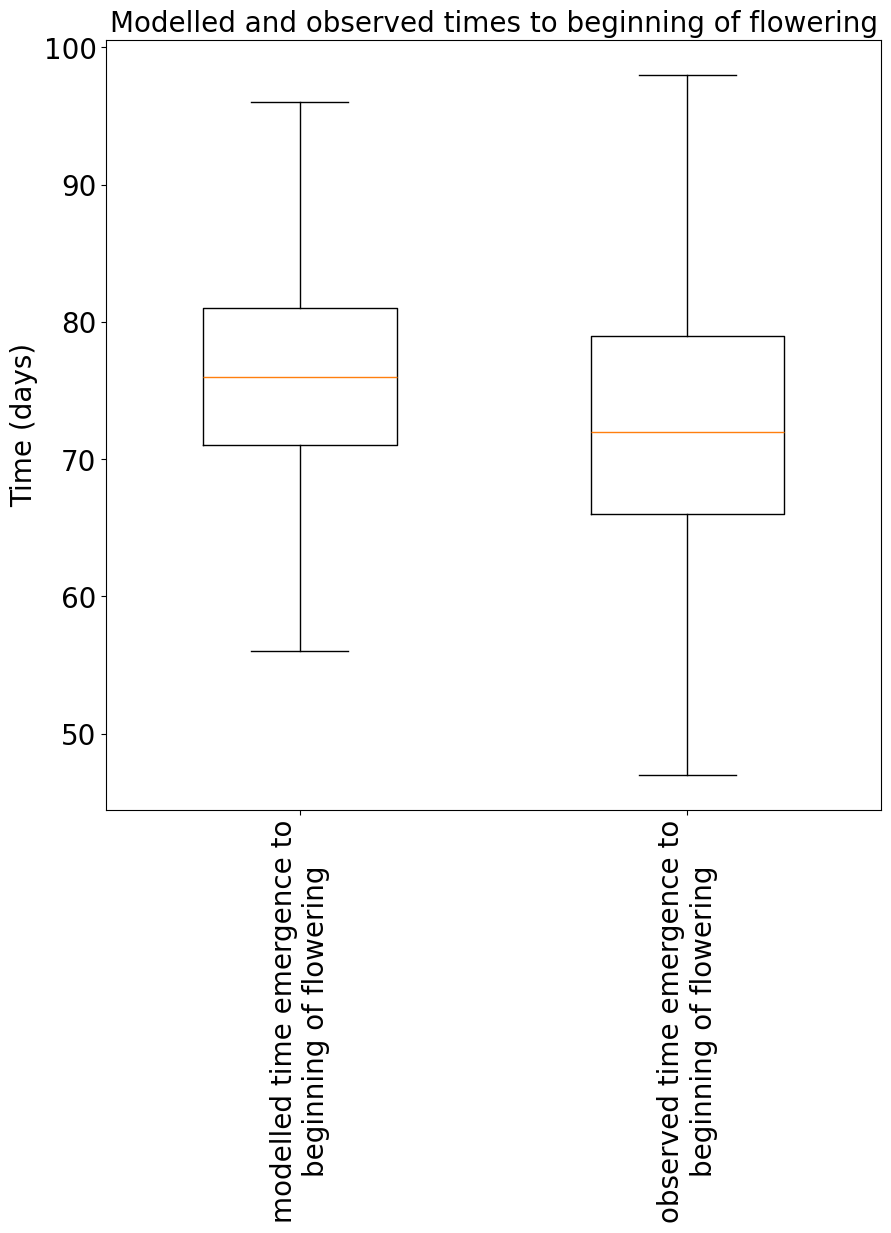

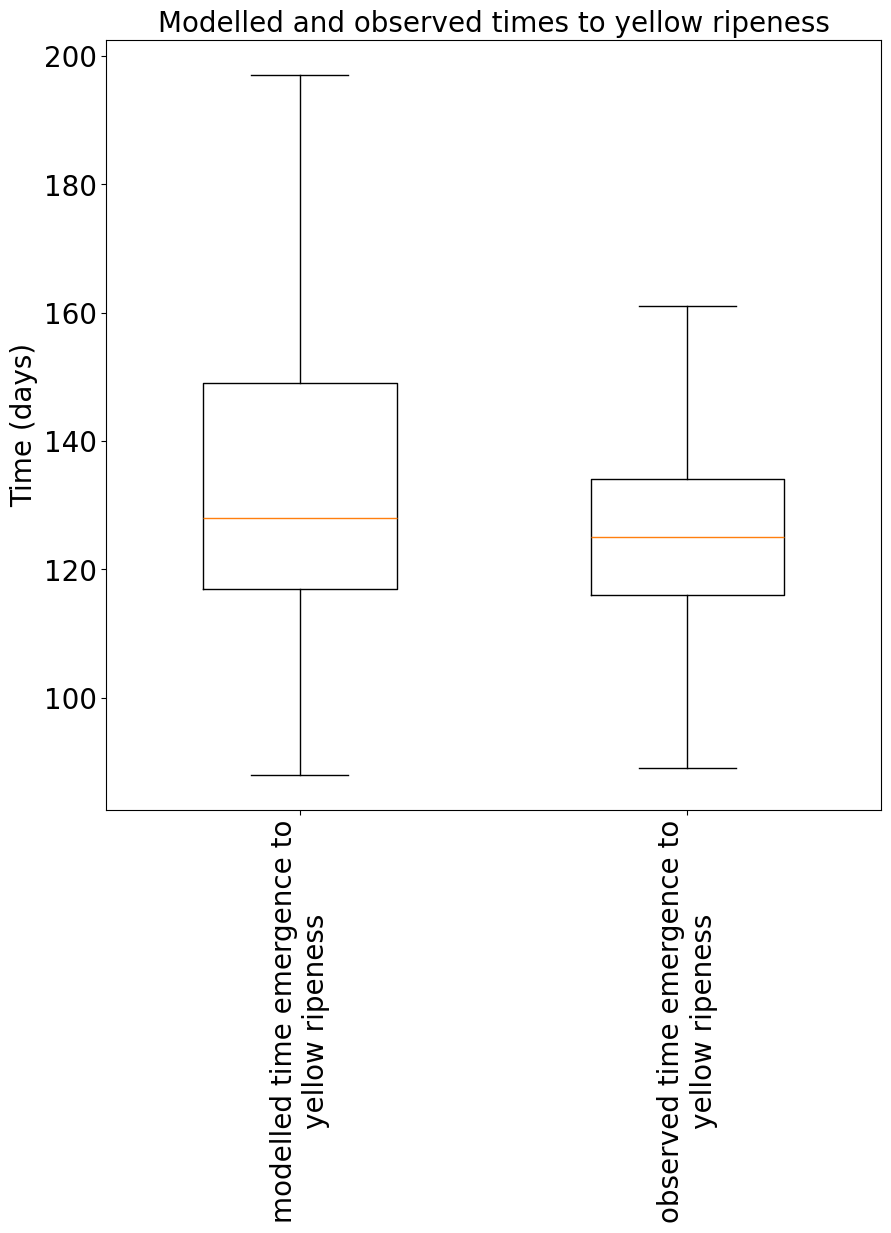

In [127]:
box_plot_modelled_observed(Maize_set.full_dataset, ['beginning of flowering', 'yellow ripeness'])